# Wrangling and Multiple Regression Analysis of Scraped Zillow Listings

## Introduction

My fiancée and I just purchased a home here in Bloomington, Indiana and the homebuying process has overwhelmed my thoughts lately. There's so much to think about and do in before purchasing the home itself, that the last thing that might be on your mind is whether or not you are getting the best value. Buyers are at the mercy of the market and while there is certainly room for negotiation, it's important to know if you're getting your money's worth.

I wanted to combine this big life event with my interest in data science, but I didn't want to take some out-of-date and perfectly clean dataset of home sales to make some value predictions from. I wanted to take real, current data from the Bloomington housing market and see if my fiancée and I got a fair price. Rather than spending all my time working on a scraper with BeautifulSoup and HTTP, I found a prebuilt tool from ScrapeHero.com. It was actually a script on their public GitHub repo that takes a zip code and a sorting method (newest, lowest price, etc.) and give you the scraped listings as a CSV file! It isn't perfect and the data needs some cleaning and merging to make a workable dataset, but it was perfect for getting started.

The goal of this project is to take the scraped zillow data, perform any necessary data wrangling/cleaning to merge the CSVs and get them into a usable format and then perform a simple analysis to look for correlation between home listing data and the listing price, so that we can forecast new listings.

## Data Wrangling

### Imports

Let's import everything we need for this project. As with most data analysis projects using Python, we'll need Numpy, Pandas, and our plotting library of choice. I like using Seaborn with Matplotlib so that I can use higher-level plotting functions where I can for simplicity. Lastly, we need a few things from Scikit-Learn for our regression analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
sns.set_style("whitegrid") # Set plot plot background style

### Reading in Scraped Data

Now, let's start working with some data. ScrapeHero's Zillow scraping script provides a simple CSV output for each zipcode. Let's read all of these into Pandas and take a look at one of them. I should note that the biggest caveat to using this script is that it is limited to one search page, so the maximum number of listings that it can pull for each zip code is about forty. This limited number of listings for the four major zip codes in Bloomington is okay for us, because it serves as a (mostly) random sample of homes for a quick analysis. It's okay for a small-scale project like this one, but if you're trying to scale up to get more accurate insight into your local housing market, a scraping service (or precollected dataset) may be required.

In [2]:
props_47401 = pd.read_csv("properties-47401.csv")
props_47403 = pd.read_csv("properties-47403.csv")
props_47404 = pd.read_csv("properties-47404.csv")
props_47408 = pd.read_csv("properties-47408.csv")

In [3]:
props_47401.head()

,title,address,city,state,postal_code,price,facts and features,real estate provider,url
0,Condo for sale,NaN,Bloomington,IN,47401,"$135,000","2 bds, 2.0 ba ,1232 sqft","Bloomington - WEICHERT, REALTORS - The Brawley...",https://www.zillow.com/homedetails/3856-S-Laur...
1,House for sale,NaN,Bloomington,IN,47401,"$630,000","5 bds, 5.0 ba ,3558 sqft",FC Tucker/Bloomington REALTORS,https://www.zillow.com/homedetails/1480-E-Sout...
2,House for sale,NaN,Bloomington,IN,47401,"$324,900","3 bds, 2.0 ba ,2166 sqft",Evergreen Real Estate & Auctions,https://www.zillow.com/homedetails/4049-E-Benn...
3,House for sale,NaN,Bloomington,IN,47401,"$349,500","4 bds, 2.0 ba ,2670 sqft",FC Tucker/Bloomington REALTORS,https://www.zillow.com/homedetails/9430-E-Cona...
4,For sale by owner,NaN,Bloomington,IN,47401,"$239,000","3 bds, 3.0 ba ,1603 sqft",NaN,https://www.zillow.com/homedetails/1993-E-Dutc...


We can see that there we're going to have to do some data wrangling in order to work with these files. We have some NaN values for missing data, home types that we may not want to include in our analysis, strings in numeric fields, as well as a compound field ('facts and features') that we'll want to break up.

### Merging Dataframes

Let's merge these dataframes together!

In [4]:
df = props_47401.append([props_47403, props_47404, props_47408])

In [5]:
df.count()

title                   160
address                   0
city                    160
state                   160
postal_code             160
price                   151
facts and features      160
real estate provider    139
url                     160
dtype: int64

Easy-peasy. We can see from the count method above we have 160 listings, but some fields have null values, which may be an issue. We're really only going to need the price field and facts and features field for our analysis, so let's work on dropping the NaN values for price because the facts and features field has the full count.

### Dropping NaNs

Here we're filtering 'price' for any instance of a NaN value and dropping that row from the dataset. We can't create a model from incomplete training data.

In [6]:
df = df.dropna(subset=['price'])

We're also going to drop any rows that don't include 'House' in the title field. This field includes other property types such as multi-family homes and empty lots, which are not relevant to our analysis.

In [7]:
props = df[df["title"].str.contains('House')]
props.count()

title                   76
address                  0
city                    76
state                   76
postal_code             76
price                   76
facts and features      76
real estate provider    76
url                     76
dtype: int64

We can see that this severely cuts our data down. However, a sample size of 76 is still fine and should give us reliable results given the assumptions of the methods we'll use.

### Converting Price String to Float

Our target field is price, so we need to make sure that the data in it is usable. The scraper populates this field with a string value including the dollar sign. We'll have to get rid of that and convert the field to a numeric type.

We'll do some regex magic to get drop the dollar sign from all the price values. In the same line, we're converting the type to float, so that we can apply mathematical functions to the field.

In [8]:
prices = props['price'].replace( '[\$,)]', '', regex=True ).astype(float)

In [9]:
prices.median()

289450.0

In [10]:
prices.describe()

count        76.000000
mean     327928.947368
std      161696.034019
min       29900.000000
25%      218675.000000
50%      289450.000000
75%      401725.000000
max      995000.000000
Name: price, dtype: float64

We have some of our first statistics! The describe method above shows us some of the characteristics of the price data. We have a sample median of \\$289,450, which is much higher than the state average of \\$158,690 (Zillow), but that's Bloomington. This median is lower than the mean, which suggests that the distribution of prices is positively skewed or that we have some outliers pushing the average up. We'll find out shortly.

### Distribution of Home Prices

Let's take a closer look at the distribution of our listing prices. We can see from the histogram/density plot below that the distribution is near-normal with a positive skew. There is a dense clustering of listing prices in the low $200k range. It's important to note that we have some outliers that may impact our analysis.

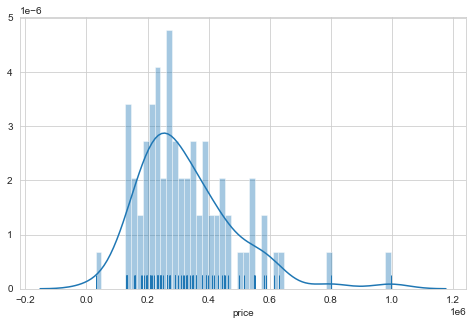

In [11]:
plt.figure(figsize=(8,5))
ax = sns.distplot(prices, bins=50, rug=True)

In the boxplot below, we can see some of the outliers I mentioned. There is a value at or near \\$800,000 and one near \\$1,000,000 that are well above the rest of the distribution. At the bottom end of the distribution there is also a value near \\$30,000 that may affect the analysis results as well. It is oftentimes not a good idea to remove outlier just because they represent extreme values, but we'll have to make a decision aboout them later.

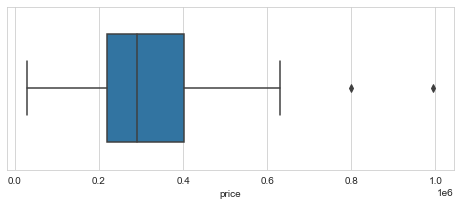

In [12]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(prices, width=0.66)

### Splitting Out Attributes

Now, we need to obtain our feature fields, which are going to be number of bedrooms, number of bathrooms, and the square footage for each listing. These, however, are combined in the facts and features field, so we need to split them out into new columns.

We do that below using the pd.str.split() method to break the values up by comma. Luckily, all of the values in this field are consistent so we don't have to do much. We also concatenate this new dataframe of the three features with the price column, to create a new dataframe, props.

In [13]:
props = pd.concat([props['price'], props['facts and features'].str.split(',', expand=True)], axis=1)

Here, we simply rename the columns to reflect the values.

In [14]:
props.columns = ['price', 'beds', 'baths', 'sqft']

In [15]:
props.head()

,price,beds,baths,sqft
1,"$630,000",5 bds,5.0 ba,3558 sqft
2,"$324,900",3 bds,2.0 ba,2166 sqft
3,"$349,500",4 bds,2.0 ba,2670 sqft
6,"$195,000",3 bds,2.0 ba,1800 sqft
10,"$614,900",5 bds,5.0 ba,4170 sqft


Looks good!

### Type Conversion

One of the final steps we need to take before we can analyze our data is to convert all of the fields to proper numeric types. Since our target, price, and our three feature fields are all quantitative, we'll use floats. We do have to work some more regex magic to do some tricky character filtering.

In [16]:
props['price'] = props['price'].str.replace(r'\D', '').astype(float) # removes all non-numeric characters
props['beds'] = props['beds'].str.replace(r'[a-z]+', '').astype(float) # removes all letters, we want to keep the decimals
props['baths'] = props['baths'].str.replace(r'[a-z]+', '').astype(float)
props['sqft'] = props['sqft'].str.replace(r'[a-z]+', '').astype(float)

In [17]:
props.head()

,price,beds,baths,sqft
1,630000.0,5.0,5.0,3558.0
2,324900.0,3.0,2.0,2166.0
3,349500.0,4.0,2.0,2670.0
6,195000.0,3.0,2.0,1800.0
10,614900.0,5.0,5.0,4170.0


We're finally done with cleaning and (almost) ready to move on to some analysis! We need to make a decision about those outliers first.

### Resolving Outliers

The three outliers that we mentioned above might give us some trouble. Like I stated before, for statistical integrity, you don't want to go removing every outlier value that won't give you the results you want. In this case, I think there are reasons to remove them. First, I think the low data point can be chalked up as a sampling error. This property is listed at \\$29,900, which is insanely low for any liveable home on a plot of land. It is likely a foreclosure auction and that is the starting bid.

The other two are trickier to make a decision on, but at \\$800,000+, I think it's safe to say that they are not worth considering for a representation of the homes we're looking for in Bloomington. One could run the regression model with or without them and results may vary. Below, we use the df.loc() method to extract all the rows with price values within a range to remove the outliers and show the distribution with a box plot.

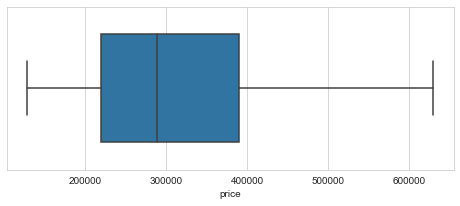

In [18]:
props = props.loc[(props['price'] > 100000) & (props['price'] < 700000)]
plt.figure(figsize=(8,3))
ax = sns.boxplot(props['price'], width=0.66)

## Analysis

We're ready to start looking at how our other attributes might be affecting the listing price for each home. We want to examine any relationship between two variables to see if there is a correlation. For example, if square footage increases, does price increase? We can visualize these relationships be creating a scatter plot for two variables at a time. Let's create a scatter matrix so that we can do this for all possible relationships. It will also show us the frequencies of values for each field.

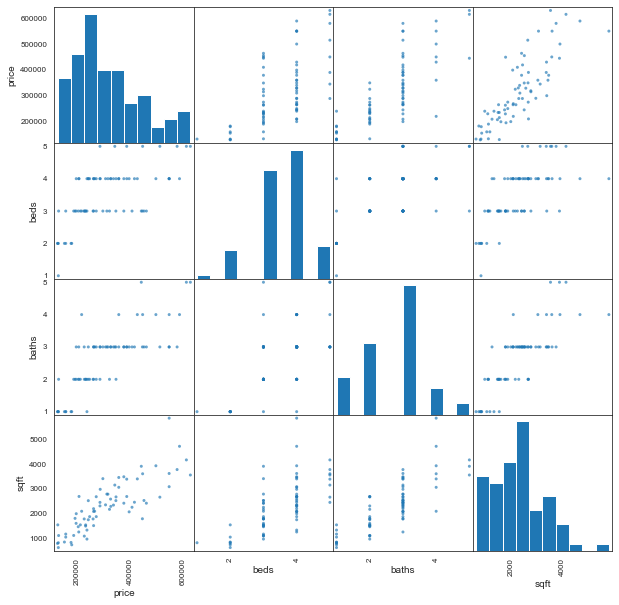

In [35]:
sns.set_style("white")
ax = pd.plotting.scatter_matrix(props, alpha=0.66, figsize=(10, 10))
plt.show()

That's a lot to look at! But we can see that the relationships appear to be linear. This makes sense, as you would expect a house with low square footage to have fewer bedrooms, fewer bathrooms, and a generally lower price than a larger home with more amenities. Linearity is also an important assumption for the regression analysis that we'll be performing on the data. However, we need to do more than assume linearity from scatter plots.

### Correlation

Let's try to quantify these relationships. The best way that we can do this, since all the fields are numeric and nominal, is to use Pearson's correlation coefficient. We do that below with df.corr().

In [20]:
props.corr(method='pearson')

,price,beds,baths,sqft
price,1.000000,0.617851,0.767242,0.828082
beds,0.617851,1.000000,0.631199,0.658591
baths,0.767242,0.631199,1.000000,0.794933
sqft,0.828082,0.658591,0.794933,1.000000


We can see above that all of the relationships between two variables are positive, with some very strong correlation in some cases. A stronger linear relationship is quantified with a number closer to 1, where no relationaship is defined as 0. For example, the strongest relationship here is between square footage and price, with a value of 0.828. The lowest is between bedrooms and price, which isn't surprising, as bedrooms generally follow square footage and bathrooms in pricing guidlines for a home. We're all set to run our regression to see if we can make predictions from our data.

### Multiple Linear Regression

Since we have one target field, price, and three attribute fields, we're going to be using a multiple linear regression model to incorporate all three feature fields in predicting a price value. We'll define our x (features) and y (target) variables below.

In [21]:
y = props['price'].values # target - must reshape series object
x = props[['beds', 'baths', 'sqft']] # features

Next, we're going to split out our training and testing data. This is optional depending on how you want to use your model. I'm not going to scrape new data or generate more than one other listing (besides my home) to test the model against. So I'm taking the dataset and splitting it into 80% training data to train the regression model on, and 20% testing data to test it's accuracy in predicting listing prices.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Alright, with that out of the way, it's time to fit the regression model to the data. Below we are setting the 'regressor' variable as an instance of the LinearRegression class from Scikit-Learn. This allows us to call the .fit() method to fit the model to our variables.

In [23]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The output above tells us that it worked with no problems! Now we can look at the results of the regression! We'll first view the intercept and coefficients for the regression lines below. Since this is a multiple regression with three independent variables, we're not going to try to visualize the model (because that would require four dimensions).

In [24]:
print(regressor.intercept_)
print(regressor.coef_)

13161.326762240089
[ 8896.63089462 54118.2658778     56.54988965]


These numbers would give us what we need to plot individual regression lines or planes if we decided to focus on one or two independent variables, respectively. But what is important is running the test values through the model and seeing how it performed. We'll test that data now.

In [25]:
y_pred = regressor.predict(x_test)

Success! Let's look at the results of the prediction against the actual data. This will give us an indication of how our model is performing. Below, we create a new dataframe and include the actual listing prices of the test data and flatten the model results into the second column.

In [26]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
predictions

,Actual,Predicted
0,275000.0,307954.310719
1,349000.0,344711.738989
2,209000.0,281676.910253
3,132000.0,119907.586452
4,219900.0,374400.452539
5,159900.0,143884.739662
6,429900.0,457490.538650
7,250000.0,262732.675735
8,234900.0,232233.986996
9,549900.0,385502.507644


It looks the model worked decently!<br>
<br>There are some predictions that are very close: row 8 at \\$235k actual \\$232k predicted
<br>as well as some that are pretty far off: row 11 at \\$240k actual and \\$178k predicted

I would guess that a lot of this variation is informative of housing data in general, the same house could be listed at wildly different prices based on location, assumptions of the seller, or as a result of a million different variables that aren't included in this data, such as a recent renovation which could drive the price up by thousands. Let's try to dig into the results a little more.

### Performance

We can visualize the house price predictions against their actual values by plotting them side-by-side on a bar graph. We'll take a random sample of ten and plot them using matplotlib.

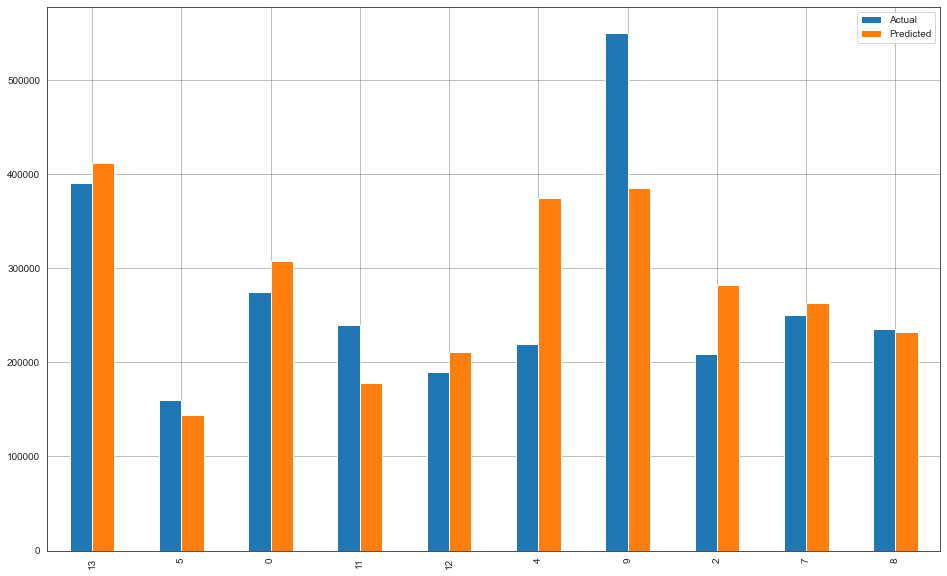

In [37]:
perf = predictions.sample(10)
perf.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Not perfect by any means, but not terrible! There are many predictions that are pretty close. Number 8 stands out as almost identical, but we saw that in the table above. 9 stands out as the worst prediction, at ~\\$164,000 off! That's a huge error. There must be something unique going on with that house. It could be a remodel or it has something to offer that drives up the value that isn't included in our three attributes. This emphasizes that our data if far from ideal and we could use some combination of more features and more samples.

To get some more indication of the performance of the model, let's get some important regression metrics below.

In [28]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))   
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 44677.85621856667
Root Mean Squared Error: 66516.42401199984


Generally mean squared error is useful, but we'll pay attention to two other metrics for this model since we can use root mean squared error in its place. The root mean squared error (RMSE) is widely used for regression metrics because it gives an indication of how errors are affecting the model. With RMSE, errors are first squared before being averaged, so this metric points out models with large errors between the actual and predicted values.

The mean absolute error (MAE) is useful because it is not so harsh on model errors. MAE tells us the mean of the absolute error for all predictions in the model. This means that all predictions are weighed equally and it gives us an idea of general performance.

The RSME score of 66516 tells us that due to some large errors, the model is being thrown off by a not insignificant amount. The MAE score of 44678 tells us that the mean amount that the predictions are off is ~\\$45,000. This is definitely more than we want to see, but there are limitations in our data and it may be performing badly because of that.

### My House Value

Limitations of our data aside, I'd like to know how the model predicts my home's value. We found it listed on Zillow for \\$186,000 with three bedrooms, one and half bathrooms, and it's 1,120 square feet. Let's make these values into an array and plug them into the model's .predict() method to see what it predicts.

In [29]:
new_house = np.array([3.0, 1.5, 1120])
new_house = new_house.reshape(1,-1)

In [30]:
print('Predicted Home Price: \n', regressor.predict(new_house))

Predicted Home Price: 
 [184364.49466694]


That's very close! The predicted value of \\$184,364 is only about 0.9\% lower than the actual listing price. While this individual result might be a fluke result of error variation, it means that the model is a step in the right direction. More data and more data attributes would likely provide a model with much higher accuracy.

## Conclusions

Overall, this was an interesting analysis and I think it leaves a lot of room to scale it up and build a more robust model. The script could be modified to automatically or at least manually scrape data for all pages in the Zillow search and increase in data points would provide a better data set to train it the model on. We fetched some raw data, cleaned and transformed it, and ran a halfway decent model on it to provide an estimate for the value of a home. In the future, I would like to scale this project up and explore different algorithmic approaches to providing a model solution. Thanks for reading!

### Note About Dropping Outliers

Improvement in MAE of ~$20000 from dropping the three outliers.

"Excluding extreme values solely due to their extremeness can distort the results of the study by removing information about the variability inherent in the study area. You’re forcing the subject area to appear less variable than it is in reality." - Jim Frost

If I was working with a larger, more representative sample of homes in my budget range, I would not be removing outliers and threatening the integrity of the analysis. In this case, an exception was made.

## Resources

ScrapeHero Zillow scraping script: https://gist.github.com/scrapehero/5f51f344d68cf2c022eb2d23a2f1cf95
<br>Data: www.zillow.com